In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import spotipy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
from dateutil import parser
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm

#os.environ['SPOTIPY_CLIENT_ID'] = 'your client id'
#os.environ['SPOTIPY_CLIENT_SECRET' = 'your client secret'

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [5]:
name = 'Arctic Monkeys'
results = spotify.search(q='artist:' + name, type='artist')
uri = results['artists']['items'][0]['uri']
results = spotify.artist_albums(uri, album_type='album')
albums = results['items']

albums_dict = {}
for i, album in enumerate(albums.__reversed__()):
    if album['name'] not in albums_dict.keys():
        albums_dict[album['name']] = album['uri']
      
albums_dict

{"Whatever People Say I Am, That's What I'm Not": 'spotify:album:50Zz8CkIhATKUlQMbHO3k1',
 'Favourite Worst Nightmare': 'spotify:album:1XkGORuUX2QGOEIL4EbJKm',
 'Favourite Worst Nightmare (Standard Version)': 'spotify:album:6rsQnwaoJHxXJRCDBPkBRw',
 'Humbug': 'spotify:album:5IEoiwkThhRmSMBANhpxl2',
 'Suck It and See': 'spotify:album:2ym2jcqckXqWeTDoxz3Kst',
 'AM': 'spotify:album:78bpIziExqiI9qztvNFlQu',
 'Tranquility Base Hotel & Casino': 'spotify:album:7v6FNgLDS8KmaWA1amUtqe',
 'Live at the Royal Albert Hall': 'spotify:album:7Heaa0B4KOxdWhSICTR2wE',
 'The Car': 'spotify:album:1kqHAucTGT1dJAtNXY8QDW'}

In [6]:
tracks_dict = {}
for key in albums_dict:
    for track in spotify.album_tracks(albums_dict[key])['items']:
        tracks_dict[track['id']] = key
        
tracks_dict

{'5eyTC5GZzpzlN7YRO9AoPf': "Whatever People Say I Am, That's What I'm Not",
 '3DQVgcqaP3iSMbaKsd57l5': "Whatever People Say I Am, That's What I'm Not",
 '7BuzJmV2h6eBbSDdRaDY7C': "Whatever People Say I Am, That's What I'm Not",
 '0hAMkY2kwdXPPDfQ1e3BmJ': "Whatever People Say I Am, That's What I'm Not",
 '111SaDBbcHW0zedi4RBHDp': "Whatever People Say I Am, That's What I'm Not",
 '64a5XZCVDWwvC7gwPPCsH6': "Whatever People Say I Am, That's What I'm Not",
 '4wMR4fRKMTyUJG6VAsmccv': "Whatever People Say I Am, That's What I'm Not",
 '56GFlp1dkt7dw56pQdTwqW': "Whatever People Say I Am, That's What I'm Not",
 '2fyIS6GXMgUcSv4oejx63f': "Whatever People Say I Am, That's What I'm Not",
 '6Slvi85s1hIaeykjvDe1xk': "Whatever People Say I Am, That's What I'm Not",
 '2zzLRQ78kKfPTx8FJQCdC2': "Whatever People Say I Am, That's What I'm Not",
 '2vQQfWTanvD99OeHLAoyhW': "Whatever People Say I Am, That's What I'm Not",
 '0eDQj41kzBhMKQIkTt6OJR': "Whatever People Say I Am, That's What I'm Not",
 '7f9I5WdyXm

In [7]:
'''
Now we need the ID of some track just to retrieve the available parameters list.
'''

track_name = input('Type the name of any track: ')

try:
    results = spotify.search(q='track:' + track_name, type='track')
    items = results['tracks']['items']
    track_id = items[0]['id']
except:
    raise Exception('Could not find any track with this name. Try again!')

print(f'''\nFirst result is "{items[0]['name']}" by "{items[0]['artists'][0]['name']}". The ID is: {track_id}''')
print('\nPlease proceed to the next cell')

Type the name of any track: as

First result is "As It Was" by "Harry Styles". The ID is: 4LRPiXqCikLlN15c3yImP7

Please proceed to the next cell


In [8]:
parameters = list(spotify.audio_features(tracks=track_id)[0].keys())
parameters

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature']

In [9]:
unwanted = ['type','id','uri','track_href','analysis_url']
parameters = [parameter for parameter in parameters if parameter not in unwanted]
parameters

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

In [10]:
features_dict = {}
for j, key in enumerate(tqdm(tracks_dict)):
    features_dict[j] = {}
    features_dict[j]['album'] = tracks_dict[key]
    track_features = spotify.audio_features(tracks=key)[0]
    for parameter in parameters:
        features_dict[j][parameter] = track_features[parameter]

features_dict

100%|███████████████████████████████████████████████████████████████████████| 112/112 [00:24<00:00,  4.56it/s]


{0: {'album': "Whatever People Say I Am, That's What I'm Not",
  'danceability': 0.387,
  'energy': 0.922,
  'key': 9,
  'loudness': -5.192,
  'mode': 0,
  'speechiness': 0.0674,
  'acousticness': 0.00487,
  'instrumentalness': 0,
  'liveness': 0.187,
  'valence': 0.417,
  'tempo': 146.478,
  'duration_ms': 222947,
  'time_signature': 4},
 1: {'album': "Whatever People Say I Am, That's What I'm Not",
  'danceability': 0.535,
  'energy': 0.948,
  'key': 6,
  'loudness': -4.19,
  'mode': 0,
  'speechiness': 0.0356,
  'acousticness': 0.00225,
  'instrumentalness': 0,
  'liveness': 0.376,
  'valence': 0.778,
  'tempo': 103.183,
  'duration_ms': 173680,
  'time_signature': 4},
 2: {'album': "Whatever People Say I Am, That's What I'm Not",
  'danceability': 0.454,
  'energy': 0.778,
  'key': 9,
  'loudness': -4.225,
  'mode': 1,
  'speechiness': 0.0449,
  'acousticness': 0.00998,
  'instrumentalness': 0,
  'liveness': 0.0427,
  'valence': 0.704,
  'tempo': 127.158,
  'duration_ms': 177947,
 

In [11]:
df = pd.DataFrame(features_dict).T
df.tail()

,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
107,The Car,0.428,0.365,4,-11.889,0,0.0276,0.78,0.0033,0.113,0.236,94.033,198554,3
108,The Car,0.548,0.328,9,-9.973,0,0.0296,0.663,0.00365,0.0972,0.343,67.023,237984,3
109,The Car,0.394,0.452,4,-9.923,0,0.0321,0.276,0.00998,0.193,0.653,169.298,244932,4
110,The Car,0.569,0.335,11,-13.637,0,0.0322,0.802,0.018,0.0834,0.388,127.587,210012,4
111,The Car,0.52,0.478,4,-10.862,1,0.0276,0.61,0.00122,0.105,0.545,82.932,167380,4


In [12]:
categorical_features = ['key', 'mode', 'time_signature']
for feature in categorical_features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df.drop([feature], axis=1), dummies], axis=1)   
df

/home/hcsg/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/hcsg/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/hcsg/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,album,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,time_signature_3,time_signature_4,time_signature_5
0,"Whatever People Say I Am, That's What I'm Not",0.387,0.922,-5.192,0.0674,0.00487,0,0.187,0.417,146.478,...,0,0,1,0,0,1,0,0,1,0
1,"Whatever People Say I Am, That's What I'm Not",0.535,0.948,-4.19,0.0356,0.00225,0,0.376,0.778,103.183,...,0,0,0,0,0,1,0,0,1,0
2,"Whatever People Say I Am, That's What I'm Not",0.454,0.778,-4.225,0.0449,0.00998,0,0.0427,0.704,127.158,...,0,0,1,0,0,0,1,0,1,0
3,"Whatever People Say I Am, That's What I'm Not",0.522,0.889,-4.137,0.0461,0.00328,0,0.345,0.852,144.499,...,0,0,0,0,0,0,1,0,1,0
4,"Whatever People Say I Am, That's What I'm Not",0.58,0.972,-4.274,0.0589,0.00384,0,0.296,0.926,105.492,...,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,The Car,0.428,0.365,-11.889,0.0276,0.78,0.0033,0.113,0.236,94.033,...,0,0,0,0,0,1,0,1,0,0
108,The Car,0.548,0.328,-9.973,0.0296,0.663,0.00365,0.0972,0.343,67.023,...,0,0,1,0,0,1,0,1,0,0
109,The Car,0.394,0.452,-9.923,0.0321,0.276,0.00998,0.193,0.653,169.298,...,0,0,0,0,0,1,0,0,1,0
110,The Car,0.569,0.335,-13.637,0.0322,0.802,0.018,0.0834,0.388,127.587,...,0,0,0,0,1,1,0,0,1,0


In [402]:
df['album'].unique()

array(["Whatever People Say I Am, That's What I'm Not",
       'Favourite Worst Nightmare',
       'Favourite Worst Nightmare (Standard Version)', 'Humbug',
       'Suck It and See', 'AM', 'Tranquility Base Hotel & Casino',
       'Live at the Royal Albert Hall', 'The Car'], dtype=object)

In [13]:
unwanted_albums = ['Favourite Worst Nightmare (Standard Version)', 'Live at the Royal Albert Hall']

for unwanted_album in unwanted_albums:
    df.drop(df[df['album'] == unwanted_album].index, inplace=True)
    
df['album'].unique()

array(["Whatever People Say I Am, That's What I'm Not",
       'Favourite Worst Nightmare', 'Humbug', 'Suck It and See', 'AM',
       'Tranquility Base Hotel & Casino', 'The Car'], dtype=object)

In [14]:
df.columns

Index(['album', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_0',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [15]:
X = df.iloc[:,1:]
scaler_X = StandardScaler()
scaler = scaler_X.fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(columns=X.columns,data=X_scaled)
y = df.iloc[:,:1]
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())

y = y.astype(np.float64)

x = X_scaled.iloc[:,:].to_numpy()
y_ = y.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

#train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20)

In [16]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.30)
val_x, test_x, val_y, test_y = train_test_split(x, y, test_size=0.50)

In [17]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(56, 27) (56, 7)
(40, 27) (40, 7)


In [18]:

type(x[0,0])

numpy.float64

In [61]:
model = HistGradientBoostingClassifier(max_iter=100)
model.fit(train_x, train_y)
ypred=model.predict(test_x)
result2 = accuracy_score(test_y,ypred)
result2

ValueError: y should be a 1d array, got an array of shape (64, 7) instead.

In [21]:
df_continuous = X_scaled.iloc[:,0:10]
df_continuous.corr()


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
danceability,1.000000,-0.265356,-0.115455,-0.332518,0.170951,-0.071650,-0.166471,0.282378,-0.248279,0.002671
energy,-0.265356,1.000000,0.860640,0.276163,-0.815666,-0.031072,0.192567,0.351733,0.147555,-0.121854
loudness,-0.115455,0.860640,1.000000,0.179392,-0.774632,-0.062182,0.248614,0.433073,0.154587,-0.163190
speechiness,-0.332518,0.276163,0.179392,1.000000,-0.169729,-0.084955,-0.081976,-0.203824,0.072112,-0.000082
acousticness,0.170951,-0.815666,-0.774632,-0.169729,1.000000,-0.083679,-0.246899,-0.410913,-0.132874,0.145817
instrumentalness,-0.071650,-0.031072,-0.062182,-0.084955,-0.083679,1.000000,-0.087968,-0.050943,0.072688,0.119384
liveness,-0.166471,0.192567,0.248614,-0.081976,-0.246899,-0.087968,1.000000,0.152638,-0.032287,-0.134088
valence,0.282378,0.351733,0.433073,-0.203824,-0.410913,-0.050943,0.152638,1.000000,0.160590,-0.297470
tempo,-0.248279,0.147555,0.154587,0.072112,-0.132874,0.072688,-0.032287,0.160590,1.000000,-0.041982
duration_ms,0.002671,-0.121854,-0.163190,-0.000082,0.145817,0.119384,-0.134088,-0.297470,-0.041982,1.000000


/tmp/ipykernel_13428/672315274.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_continuous.corr(), dtype=np.bool))


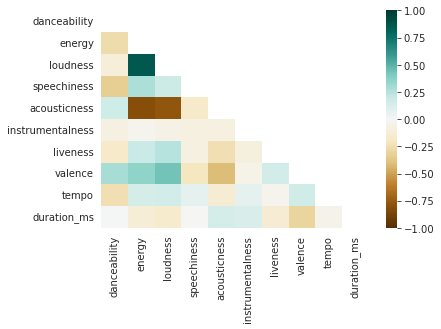

In [22]:
mask = np.triu(np.ones_like(df_continuous.corr(), dtype=np.bool))
with sns.axes_style('white'):
    sns.heatmap(df_continuous.corr(), cmap='BrBG', mask=mask, vmin=-1, vmax=1)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])

from sklearn.model_selection import cross_validate

scores = cross_validate(pipeline, train_x, train_y)
scores

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV

classifiers = [
    BernoulliNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    ExtraTreesClassifier(),
    KNeighborsClassifier(n_neighbors=3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GradientBoostingClassifier(),
    GaussianNB(),
    LabelPropagation(),
    LabelSpreading(),
    LinearDiscriminantAnalysis(),
    LinearSVC(multi_class='crammer_singer'),
    LogisticRegression(multi_class='multinomial'),
    LogisticRegressionCV(multi_class='multinomial'),
    MLPClassifier(),
    NearestCentroid(),
    QuadraticDiscriminantAnalysis(),
    RadiusNeighborsClassifier(),
    RandomForestClassifier(),
    RidgeClassifier(),
    RidgeClassifierCV()
]

clfs = []

for classifier in classifiers:
    clfs.append(classifier)

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, train_x, train_y)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
 

---------------------------------
BernoulliNB()
-----------------------------------
fit_time  mean  0.0008342266082763672
fit_time  std  0.00013950107197905514
score_time  mean  0.0
score_time  std  0.0
test_score  mean  nan
test_score  std  nan
---------------------------------
LogisticRegression()
-----------------------------------
fit_time  mean  0.0008432388305664063
fit_time  std  0.00020389449830305006
score_time  mean  0.0
score_time  std  0.0
test_score  mean  nan
test_score  std  nan
---------------------------------
DecisionTreeClassifier()
-----------------------------------
fit_time  mean  0.0019547462463378905
fit_time  std  0.0017847746371350433
score_time  mean  0.0007716655731201172
score_time  std  6.363562938581972e-05
test_score  mean  0.32121212121212117
test_score  std  0.12211782836127201
---------------------------------
ExtraTreeClassifier()
-----------------------------------
fit_time  mean  0.0010582923889160157
fit_time  std  0.0004348324139494313
score_time

/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 494, in fit
    y = column_or_1d(y, warn=True)
  File "/

/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hcsg/anaconda3/lib/python3.9/site-packages

---------------------------------
MLPClassifier()
-----------------------------------
fit_time  mean  0.10444498062133789
fit_time  std  0.01278099542663175
score_time  mean  0.0015697956085205078
score_time  std  0.0003245938587757952
test_score  mean  0.17575757575757575
test_score  std  0.08865902326259269
---------------------------------
NearestCentroid()
-----------------------------------
fit_time  mean  0.0005326747894287109
fit_time  std  3.202464766447425e-05
score_time  mean  0.0
score_time  std  0.0
test_score  mean  nan
test_score  std  nan
---------------------------------
QuadraticDiscriminantAnalysis()
-----------------------------------
fit_time  mean  0.0006299972534179688
fit_time  std  0.00019360061930992026
score_time  mean  0.0
score_time  std  0.0
test_score  mean  nan
test_score  std  nan
---------------------------------
RadiusNeighborsClassifier()
-----------------------------------
fit_time  mean  0.001823759078979492
fit_time  std  0.0006513715941181425
scor

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error
classifiers_1 = [
    XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27),
    KNeighborsClassifier(),
    DecisionTreeClassifier(max_depth=70),
    RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42),
    ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),   
]

classifiers_2 = [
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=.1),
    GradientBoostingClassifier(learning_rate=0.1, random_state=10),
    HistGradientBoostingClassifier(max_iter=100)
]

for classifier in classifiers_1:
    print(str(classifier))
    classifier.fit(train_x,train_y)
    ypred=classifier.predict(test_x)
    result1 = classification_report(test_y, ypred)
    print (result1)
    #sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)
    result2 = accuracy_score(test_y,ypred)
    print('Accuracy:',result2)
    
tmp_df = pd.DataFrame(train_y)
train_y_decoded = tmp_df.apply(lambda x: x.argmax(), axis=1).values
tmp_df = pd.DataFrame(test_y)
test_y_decoded = tmp_df.apply(lambda x: x.argmax(), axis=1).values
    
for classifier in classifiers_2:
    
    print(str(classifier))

    classifier.fit(train_x,train_y_decoded)
    ypred=classifier.predict(test_x)
    tmp_df = pd.DataFrame(ypred,columns=['album'])
   
    ypred_encoded = pd.get_dummies(tmp_df['album']).to_numpy()


    result1 = classification_report(test_y, ypred_encoded)
    
    print (result1)
    #sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)
    result2 = accuracy_score(test_y,ypred_encoded)
    print('Accuracy:',result2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)


/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hcsg/anaconda3/lib/python3.9/si

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         3
           2       1.00      0.83      0.91         6
           3       0.75      1.00      0.86         3
           4       1.00      0.60      0.75         5
           5       0.75      0.43      0.55         7
           6       1.00      1.00      1.00         9

   micro avg       0.94      0.80      0.86        40
   macro avg       0.93      0.82      0.85        40
weighted avg       0.94      0.80      0.85        40
 samples avg       0.80      0.80      0.80        40

Accuracy: 0.8
KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.50      0.33      0.40         3
           2       1.00      0.33      0.50         6
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.

In [326]:
help(hgbc.get_params())

Help on dict object:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Built-in subclasses:
 |      StgDict
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>va

In [33]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

hgbc = HistGradientBoostingClassifier(max_iter=100)

param_grid = {
 'max_iter': [1000,1200,1500],
 'learning_rate': [0.1],
 'max_depth' : [25, 50, 75],
 'l2_regularization': [1.5],
 'scoring': ['f1_micro'],
 'random_state' : [13],
 }

scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
        }

model_grid_search = GridSearchCV(hgbc, param_grid=param_grid,
                                 n_jobs=2, cv=2, scoring=scorers, refit='accuracy_score')
model_grid_search.fit(train_x, train_y_decoded)

accuracy = model_grid_search.score(test_x,test_y_decoded)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/skl

/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/skl

/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/home/hcsg/anaconda3/lib/python3.9/site-packages/skl

The test accuracy score of the grid-searched pipeline is: 0.50
CPU times: user 48.7 s, sys: 2.14 s, total: 50.8 s
Wall time: 20.4 s


In [34]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

hgbc = HistGradientBoostingClassifier(max_iter=100)

param_grid = {
 'max_iter': [1000,1200,1500],
 'learning_rate': [0.1],
 'max_depth' : [25, 50, 75],
 'l2_regularization': [1.5],
 'scoring': ['f1_micro'],
 'random_state' : [13],
 }

# scorers = {
#         'precision_score': make_scorer(precision_score),
#         'recall_score': make_scorer(recall_score),
#         'accuracy_score': make_scorer(accuracy_score)
#         }

model_grid_search = GridSearchCV(hgbc, param_grid=param_grid,
                                 n_jobs=2, cv=5, scoring='f1_micro', verbose=2, refit=True)
model_grid_search.fit(train_x, train_y_decoded)

accuracy = model_grid_search.score(test_x,test_y_decoded)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The test accuracy score of the grid-searched pipeline is: 0.44
CPU times: user 1min 2s, sys: 2.71 s, total: 1min 5s
Wall time: 1min 17s


In [35]:
# Print the best parameters found
print(model_grid_search.best_params_)
# Print the best scores found


{'l2_regularization': 1.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 1200, 'random_state': 13, 'scoring': 'f1_micro'}


In [36]:

ypred=model_grid_search.predict(test_x)
tmp_df = pd.DataFrame(ypred,columns=['album'])

ypred_encoded = pd.get_dummies(tmp_df['album']).to_numpy()


result1 = classification_report(test_y, ypred_encoded,output_dict=True)
df_report = pd.DataFrame(result1).iloc[:-1, :-4].T

keys_encoded = list(result1.keys())[:-4]
keys_encoded = [int(key_encoded) for key_encoded in keys_encoded]
df_report.index = pd.Series(le.inverse_transform(keys_encoded))

sns.reset_orig()
with sns.axes_style('white'):
    a = sns.set(rc={})
    sns.heatmap(df_report, annot=True)

#sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)
result2 = accuracy_score(test_y,ypred_encoded)
#print('Accuracy:',result2)

ValueError: Multi-label binary indicator input with different numbers of labels

In [394]:
rc

NameError: name 'rc' is not defined

In [336]:
hgbc = HistGradientBoostingClassifier(max_iter=100)
print(vars(hgbc))

hgbc.fit(train_x, train_y_decoded)
accuracy = hgbc.score(test_x,test_y_decoded)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

{'loss': 'auto', 'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 31, 'max_depth': None, 'min_samples_leaf': 20, 'l2_regularization': 0.0, 'max_bins': 255, 'monotonic_cst': None, 'categorical_features': None, 'warm_start': False, 'early_stopping': 'auto', 'scoring': 'loss', 'validation_fraction': 0.1, 'n_iter_no_change': 10, 'tol': 1e-07, 'verbose': 0, 'random_state': None}
The test accuracy score of the grid-searched pipeline is: 0.85


In [263]:
label = pd.DataFrame(train_y)
train_y_decoded = label.apply(lambda x: x.argmax(), axis=1).values

label = pd.DataFrame(test_y)
test_y_decoded = label.apply(lambda x: x.argmax(), axis=1).values

label = pd.DataFrame(val_y)
val_y_decoded = label.apply(lambda x: x.argmax(), axis=1).values

In [241]:
xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

params = {"objective":'binary:logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
data_dmatrix = DMatrix(data=X_scaled,label=y, enable_categorical=True)
cv_results = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

print((cv_results["test-rmse-mean"]).tail(1))


xg_clf = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)



RMSE: 3.455069
49    0.386624
Name: test-rmse-mean, dtype: float64


In [243]:
import matplotlib.pyplot as pl
import graphviz
from xgboost import plot_tree
from graphviz import Digraph

import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

xgb.to_graphviz(xg_clf, num_trees=0, rankdir='LR')


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

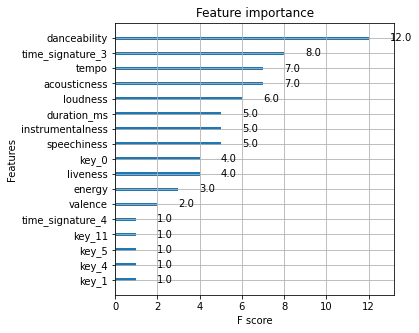

In [251]:
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams["figure.facecolor"] = "b"
plt.show()

In [188]:
# knn_clf=KNeighborsClassifier()
# knn_clf.fit(train_x,train_y)
# ypred=knn_clf.predict(test_x)

# dtc_clf=DecisionTreeClassifier(max_depth=70)
# dtc_clf.fit(train_x,train_y)
# ypred=dtc_clf.predict(test_x)

rfc_clf=RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rfc_clf.fit(train_x,train_y)
ypred=rfc_clf.predict(test_x)


In [189]:


result1 = classification_report(test_y, ypred)
print('Classification Report:',)
print (result1)
result2 = accuracy_score(test_y,ypred)
print('Accuracy:',result2)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      0.38      0.55         8
           2       1.00      1.00      1.00         2
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         5
           5       1.00      0.33      0.50         3
           6       1.00      0.78      0.88         9

   micro avg       0.94      0.75      0.83        40
   macro avg       0.96      0.76      0.81        40
weighted avg       0.95      0.75      0.81        40
 samples avg       0.75      0.75      0.75        40

Accuracy: 0.75


/home/hcsg/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
DecisionTreeClassifier(max_depth=5)

In [46]:
df2.to_csv('df22.csv')

In [47]:
df2 = pd.read_csv('df22.csv')

In [48]:
df2.drop(['track_number','name','id'], axis=1)

,Unnamed: 0,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,2006-01-29,0.387,0.922,9.0,-5.192,0.0,0.0674,0.00487,0.00000,0.1870,0.417,146.478,222947.0,4.0
1,1,2006-01-29,0.535,0.948,6.0,-4.190,0.0,0.0356,0.00225,0.00000,0.3760,0.778,103.183,173680.0,4.0
2,2,2006-01-29,0.454,0.778,9.0,-4.225,1.0,0.0449,0.00998,0.00000,0.0427,0.704,127.158,177947.0,4.0
3,3,2006-01-29,0.522,0.889,1.0,-4.137,1.0,0.0461,0.00328,0.00000,0.3450,0.852,144.499,141133.0,4.0
4,4,2006-01-29,0.580,0.972,11.0,-4.274,0.0,0.0589,0.00384,0.00000,0.2960,0.926,105.492,130813.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,2022-10-21,0.428,0.365,4.0,-11.889,0.0,0.0276,0.78000,0.00330,0.1130,0.236,94.033,198554.0,3.0
76,76,2022-10-21,0.548,0.328,9.0,-9.973,0.0,0.0296,0.66300,0.00365,0.0972,0.343,67.023,237984.0,3.0
77,77,2022-10-21,0.394,0.452,4.0,-9.923,0.0,0.0321,0.27600,0.00998,0.1930,0.653,169.298,244932.0,4.0
78,78,2022-10-21,0.569,0.335,11.0,-13.637,0.0,0.0322,0.80200,0.01800,0.0834,0.388,127.587,210012.0,4.0


In [31]:
df2.insert(0, 'album', df2.pop('album'))
df2

KeyError: 'album'